In [1]:
import numpy as np
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy.random import random
from scipy.linalg import sqrtm
import cv2
import glob
import tensorflow as tf
import tensorflow.keras as K
import os
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import PIL
import PIL.Image
from sklearn.model_selection import train_test_split,StratifiedKFold
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
tfds.disable_progress_bar()
autotune = tf.data.experimental.AUTOTUNE
def normalize_img(img):
    img = tf.cast(img, dtype=tf.float32)
    # Map values in the range [-1, 1]
    return (img / 127.5) - 1.0

def normalize_img(img):
    img = tf.cast(img, dtype=tf.float32)
    # Map values in the range [-1, 1]
    return (img / 127.5) - 1.0


def preprocess_train_image(img):
    # Random flip
    # Resize to the original size first
    # Normalize the pixel values in the range [-1, 1]
    img = normalize_img(img)
    return img


def preprocess_test_image(img, label):
    # Only resizing and normalization for the test images.
    img = tf.image.resize(img, [input_img_size[0], input_img_size[1]])
    img = normalize_img(img)
    return img

input_img_size = (256,256, 3)

orig_img_size = (286, 286)
# Weights initializer for the layers.
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# Gamma initializer for instance normalization.
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

buffer_size = 256
batch_size = 1
# calculate frechet inception distance
def calculate_fid(act1, act2):
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = np.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid

class ReflectionPadding2D(layers.Layer):
    """Implements Reflection Padding as a layer.

    Args:
        padding(tuple): Amount of padding for the
        spatial dimensions.

    Returns:
        A padded tensor with the same type as the input tensor.
    """

    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super().__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],
        ]
        return tf.pad(input_tensor, padding_tensor, mode="REFLECT")


def residual_block(
    x,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="valid",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    dim = x.shape[-1]
    input_tensor = x

    x = ReflectionPadding2D()(input_tensor)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = activation(x)

    x = ReflectionPadding2D()(x)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.add([input_tensor, x])
    return x


def downsample(
    x,
    filters,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2D(
        filters,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x


def upsample(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    kernel_initializer=kernel_init,
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2DTranspose(
        filters,
        kernel_size,
        strides=strides,
        padding=padding,
        kernel_initializer=kernel_initializer,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x

def get_resnet_generator(
    filters=64,
    num_downsampling_blocks=2,
    num_residual_blocks=9,
    num_upsample_blocks=2,
    gamma_initializer=gamma_init,
    name=None,
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = ReflectionPadding2D(padding=(3, 3))(img_input)
    x = layers.Conv2D(filters, (7, 7), kernel_initializer=kernel_init, use_bias=False)(
        x
    )
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.Activation("relu")(x)

    # Downsampling
    for _ in range(num_downsampling_blocks):
        filters *= 2
        x = downsample(x, filters=filters, activation=layers.Activation("relu"))

    # Residual blocks
    for _ in range(num_residual_blocks):
        x = residual_block(x, activation=layers.Activation("relu"))

    # Upsampling
    for _ in range(num_upsample_blocks):
        filters //= 2
        x = upsample(x, filters, activation=layers.Activation("relu"))

    # Final block
    x = ReflectionPadding2D(padding=(3, 3))(x)
    x = layers.Conv2D(3, (7, 7), padding="valid")(x)
    x = layers.Activation("tanh")(x)

    model = keras.models.Model(img_input, x, name=name)
    return model

def get_discriminator(
    filters=64, kernel_initializer=kernel_init, num_downsampling=3, name=None
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = layers.Conv2D(
        filters,
        (4, 4),
        strides=(2, 2),
        padding="same",
        kernel_initializer=kernel_initializer,
    )(img_input)
    x = layers.LeakyReLU(0.2)(x)

    num_filters = filters
    for num_downsample_block in range(3):
        num_filters *= 2
        if num_downsample_block < 2:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(2, 2),
            )
        else:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(1, 1),
            )

    x = layers.Conv2D(
        1, (4, 4), strides=(1, 1), padding="same", kernel_initializer=kernel_initializer
    )(x)

    model = keras.models.Model(inputs=img_input, outputs=x, name=name)
    return model


# Get the generators
gen_G = get_resnet_generator(name="generator_G")
gen_F = get_resnet_generator(name="generator_F")

# Get the discriminators
disc_X = get_discriminator(name="discriminator_X")
disc_Y = get_discriminator(name="discriminator_Y")

class CycleGan(keras.Model):
    def __init__(
        self,
        generator_G,
        generator_F,
        discriminator_X,
        discriminator_Y,
        lambda_cycle=10.0,
        lambda_identity=0.5,
    ):
        super().__init__()
        self.gen_G = generator_G
        self.gen_F = generator_F
        self.disc_X = discriminator_X
        self.disc_Y = discriminator_Y
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity

    def compile(
        self,
        gen_G_optimizer,
        gen_F_optimizer,
        disc_X_optimizer,
        disc_Y_optimizer,
        gen_loss_fn,
        disc_loss_fn,
    ):
        super().compile()
        self.gen_G_optimizer = gen_G_optimizer
        self.gen_F_optimizer = gen_F_optimizer
        self.disc_X_optimizer = disc_X_optimizer
        self.disc_Y_optimizer = disc_Y_optimizer
        self.generator_loss_fn = gen_loss_fn
        self.discriminator_loss_fn = disc_loss_fn
        self.cycle_loss_fn = keras.losses.MeanAbsoluteError()
        self.identity_loss_fn = keras.losses.MeanAbsoluteError()

    def train_step(self, batch_data):
        # x is Horse and y is zebra
        real_x, real_y = batch_data

        # For CycleGAN, we need to calculate different
        # kinds of losses for the generators and discriminators.
        # We will perform the following steps here:
        #
        # 1. Pass real images through the generators and get the generated images
        # 2. Pass the generated images back to the generators to check if we
        #    we can predict the original image from the generated image.
        # 3. Do an identity mapping of the real images using the generators.
        # 4. Pass the generated images in 1) to the corresponding discriminators.
        # 5. Calculate the generators total loss (adverserial + cycle + identity)
        # 6. Calculate the discriminators loss
        # 7. Update the weights of the generators
        # 8. Update the weights of the discriminators
        # 9. Return the losses in a dictionary

        with tf.GradientTape(persistent=True) as tape:
            # Horse to fake zebra
            fake_y = self.gen_G(real_x, training=True)
            # Zebra to fake horse -> y2x
            fake_x = self.gen_F(real_y, training=True)

            # Cycle (Horse to fake zebra to fake horse): x -> y -> x
            cycled_x = self.gen_F(fake_y, training=True)
            # Cycle (Zebra to fake horse to fake zebra) y -> x -> y
            cycled_y = self.gen_G(fake_x, training=True)

            # Identity mapping
            same_x = self.gen_F(real_x, training=True)
            same_y = self.gen_G(real_y, training=True)

            # Discriminator output
            disc_real_x = self.disc_X(real_x, training=True)
            disc_fake_x = self.disc_X(fake_x, training=True)

            disc_real_y = self.disc_Y(real_y, training=True)
            disc_fake_y = self.disc_Y(fake_y, training=True)

            # Generator adverserial loss
            gen_G_loss = self.generator_loss_fn(disc_fake_y)
            gen_F_loss = self.generator_loss_fn(disc_fake_x)

            # Generator cycle loss
            cycle_loss_G = self.cycle_loss_fn(real_y, cycled_y) * self.lambda_cycle
            cycle_loss_F = self.cycle_loss_fn(real_x, cycled_x) * self.lambda_cycle

            # Generator identity loss
            id_loss_G = (
                self.identity_loss_fn(real_y, same_y)
                * self.lambda_cycle
                * self.lambda_identity
            )
            id_loss_F = (
                self.identity_loss_fn(real_x, same_x)
                * self.lambda_cycle
                * self.lambda_identity
            )

            # Total generator loss
            total_loss_G = gen_G_loss + cycle_loss_G + id_loss_G
            total_loss_F = gen_F_loss + cycle_loss_F + id_loss_F

            # Discriminator loss
            disc_X_loss = self.discriminator_loss_fn(disc_real_x, disc_fake_x)
            disc_Y_loss = self.discriminator_loss_fn(disc_real_y, disc_fake_y)

        # Get the gradients for the generators
        grads_G = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
        grads_F = tape.gradient(total_loss_F, self.gen_F.trainable_variables)

        # Get the gradients for the discriminators
        disc_X_grads = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
        disc_Y_grads = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

        # Update the weights of the generators
        self.gen_G_optimizer.apply_gradients(
            zip(grads_G, self.gen_G.trainable_variables)
        )
        self.gen_F_optimizer.apply_gradients(
            zip(grads_F, self.gen_F.trainable_variables)
        )

        # Update the weights of the discriminators
        self.disc_X_optimizer.apply_gradients(
            zip(disc_X_grads, self.disc_X.trainable_variables)
        )
        self.disc_Y_optimizer.apply_gradients(
            zip(disc_Y_grads, self.disc_Y.trainable_variables)
        )

        return {
            "G_loss": total_loss_G,
            "F_loss": total_loss_F,
            "D_X_loss": disc_X_loss,
            "D_Y_loss": disc_Y_loss,
        }
adv_loss_fn = keras.losses.MeanSquaredError()

# Define the loss function for the generators
def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
    return fake_loss


# Define the loss function for the discriminators
def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5
cycle_gan_model = CycleGan(
        generator_G=gen_G, generator_F=gen_F, discriminator_X=disc_X, discriminator_Y=disc_Y
    )

/home/dgxadmin/anaconda3/envs/LeeYS/lib/python3.6/site-packages/tensorflow_addons/utils/ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.3.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [4]:

y_filenames = glob.glob('../data/256data/output/*.tiff')

x_filenames = [f.replace('/output', '/input') for f in y_filenames]
cycle_gan_model.compile(
        gen_G_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
        gen_F_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
        disc_X_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
        disc_Y_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
        gen_loss_fn=generator_loss_fn,
        disc_loss_fn=discriminator_loss_fn,
    )
cycle_gan_model.built = True

In [7]:
x_file = np.zeros((len(x_filenames),256,256,3))
y_file = np.zeros((len(y_filenames),256,256,3))
for (index, image) in enumerate(x_filenames[:]):
    x_file[index] =np.array(PIL.Image.open(image))
    
# 검증용  및 변병여부 
for (index, image) in enumerate(y_filenames[:]):
    y_file[index] = np.array(PIL.Image.open(image))
    
tf_x_file=tf.data.Dataset.from_tensor_slices(x_file)
tf_y_file=tf.data.Dataset.from_tensor_slices(y_file)
tf_x_file=(tf_x_file.map(preprocess_train_image, num_parallel_calls=autotune).cache()
    .batch(batch_size))
tf_y_file=(tf_y_file.map(preprocess_train_image, num_parallel_calls=autotune).cache()
    .batch(batch_size))


In [8]:

cycle_gan_model.compile(
        gen_G_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
        gen_F_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
        disc_X_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
        disc_Y_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
        gen_loss_fn=generator_loss_fn,
        disc_loss_fn=discriminator_loss_fn,
    )
def SSIM(x, y):
    def mean(img):
        return np.mean(img)
        
    def sigma(img):
        return np.std(img)
    
    def cov(img1, img2):
        img1_ = np.array(img1[:,:], dtype=np.float64)
        img2_ = np.array(img2[:,:], dtype=np.float64)
                        
        return np.mean(img1_ * img2_) - mean(img1) * mean(img2)
    
    K1 = 0.01
    K2 = 0.03
    L = 256 # when each pixel spans 0 to 255
   
    C1 = K1 * K1 * L * L
    C2 = K2 * K2 * L * L
    C3 = C2 / 2
        
    l = (2 * mean(x) * mean(y) + C1) / (mean(x)**2 + mean(y)**2 + C1)
    c = (2 * sigma(x) * sigma(y) + C2) / (sigma(x)**2 + sigma(y)**2 + C2)
    s = (cov(x, y) + C3) / (sigma(x) * sigma(y) + C3)
        
    return l * c * s
def calculate_fid(act1, act2):
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), cov(act1.mean(axis=2), rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), cov(act2.mean(axis=2), rowvar=False)
	# calculate sum squared difference between means
	ssdiff = np.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid
cycle_gan_model.built = True
fid_mean=[]
fid_entire=[]
ssim_mean=[]
ssim_entire=[]
for j in range(1,115):
    epoch_str = str(j)
    cycle_gan_model.load_weights("../model/256data/tileCycleGan/cyclegan_checkpoints_"+epoch_str.zfill(3)+".h5")
    fid_epoch=[]
    ssim_epoch=[]
    for i, img in enumerate(zip(tf_x_file.take(10),tf_y_file.take(10))):
        prediction = cycle_gan_model.gen_G(img[0])[0].numpy()
        img1 = (img[0][0]).numpy()
        dst_img=(img[1][0] ).numpy()
        fid=calculate_fid(dst_img,prediction)
        ssim=SSIM(img1,prediction)
        fid_epoch.append(fid)
        ssim_epoch.append(ssim)
        if(i<4):
            prediction = keras.preprocessing.image.array_to_img(prediction)
            prediction.save(
                    "../data/256data/img_pred/generated_img_{epoch}_{i}.png".format(i=i, epoch=j)
                )
    fid_entire.append(fid_epoch)
    ssim_entire.append(ssim_epoch)
    fid_mean.append(sum(fid_epoch)/len(fid_epoch))
    ssim_mean.append(sum(ssim_epoch)/len(ssim_epoch))
    a=sum(fid_epoch)/len(fid_epoch)
    b=sum(ssim_epoch)/len(ssim_epoch)
    print('FID : %.3f SSIM : %.3f' %(a,b))

FID : 8.592 SSIM : 0.999
FID : 6.100 SSIM : 0.999
FID : 5.717 SSIM : 0.999
FID : 4.415 SSIM : 1.000
FID : 5.000 SSIM : 1.000
FID : 4.004 SSIM : 1.000
FID : 2.952 SSIM : 1.000
FID : 2.316 SSIM : 1.000
FID : 2.291 SSIM : 1.000
FID : 2.286 SSIM : 1.000
FID : 2.383 SSIM : 1.000
FID : 1.836 SSIM : 1.000
FID : 1.556 SSIM : 1.000
FID : 1.672 SSIM : 1.000
FID : 1.474 SSIM : 1.000
FID : 1.330 SSIM : 1.000
FID : 2.892 SSIM : 1.000
FID : 1.445 SSIM : 1.000
FID : 1.441 SSIM : 1.000
FID : 1.991 SSIM : 1.000
FID : 2.266 SSIM : 1.000
FID : 1.942 SSIM : 1.000
FID : 1.658 SSIM : 1.000
FID : 1.152 SSIM : 1.000
FID : 1.553 SSIM : 1.000
FID : 3.038 SSIM : 1.000
FID : 1.577 SSIM : 1.000
FID : 1.426 SSIM : 1.000
FID : 1.464 SSIM : 1.000
FID : 1.747 SSIM : 1.000
FID : 0.962 SSIM : 1.000
FID : 1.303 SSIM : 1.000
FID : 3.498 SSIM : 1.000
FID : 1.600 SSIM : 1.000
FID : 1.846 SSIM : 1.000
FID : 1.550 SSIM : 1.000
FID : 2.051 SSIM : 1.000
FID : 2.594 SSIM : 1.000
FID : 2.536 SSIM : 1.000
FID : 2.022 SSIM : 1.000


KeyboardInterrupt: 

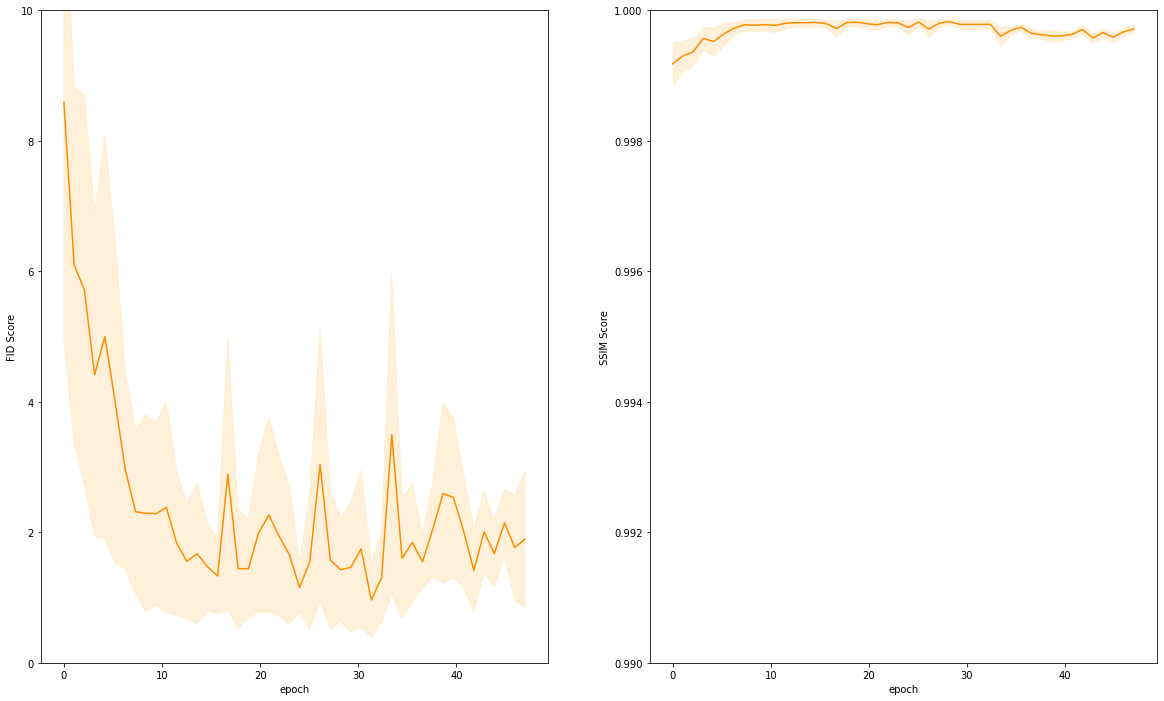

In [10]:
def mean(inp):
    result = 0
    len_inp = len(inp)    
    for i in inp:
        result += i
    result = result / len_inp
    return result
def var(inp):
    result = 0
    len_inp = len(inp)
    for i in inp:
        result += (i - mean(inp)) ** 2
    result = result / len_inp
    return result
def sqrt(inp):
    result = inp/2
    for i in range(30):
        result = (result + (inp / result)) / 2
    return result
def std(inp):
    result = sqrt(var(inp))
    return result
def ci95(inp):
    max95 = mean(inp) + (1.96 * (std(inp) / sqrt(len(inp))))
    min95 = mean(inp) - (1.96 * (std(inp) / sqrt(len(inp))))
    return min95, max95

def ci99(inp):
    max99 = mean(inp) + (2.58 * (std(inp) / sqrt(len(inp))))
    min99 = mean(inp) - (2.58 * (std(inp) / sqrt(len(inp))))
    return min99, max99

fid_95ci=[]
fid_99ci=[]
ssim_95ci=[]
ssim_99ci=[]
for i in range(len(fid_entire)):
    fid_95ci.append(ci95(fid_entire[i]))
    fid_99ci.append(ci99(fid_entire[i]))
    ssim_95ci.append(ci95(ssim_entire[i]))
    ssim_99ci.append(ci99(ssim_entire[i]))
    

x = np.linspace(0, 47,46)
plt.figure(figsize=(20,12))
plt.subplot(1, 2, 1)
plt.plot(x,fid_mean,color="darkorange")
plt.xlabel('epoch')
plt.ylim([0, 10])
plt.ylabel('FID Score')
plt.fill_between(x,np.array(fid_95ci)[:,0],np.array(fid_95ci)[:,1], color='moccasin',alpha = 0.5)
plt.subplot(1, 2, 2) 
plt.plot(x,ssim_mean,color="darkorange")
plt.ylim([0.99, 1])
plt.fill_between(x,np.array(ssim_95ci)[:,0],np.array(ssim_95ci)[:,1], color='moccasin',alpha = 0.5)
plt.xlabel('epoch')
plt.ylabel('SSIM Score')
plt.show()

In [30]:
cycle_gan_model.load_weights("../model/256data/tileCycleGan/cyclegan_checkpoints_031.h5")
pred_x=np.zeros((4,256,256,3))
pred_x_filenames = glob.glob('../data/256data/img/*.tiff')
from PIL import Image
for (index, image) in enumerate(pred_x_filenames[:]):
    pred_x[index] = np.array(Image.open(image))

tf_x_file=tf.data.Dataset.from_tensor_slices(pred_x)
tf_x_file=(tf_x_file.map(preprocess_train_image, num_parallel_calls=autotune).cache()
    .batch(batch_size))  

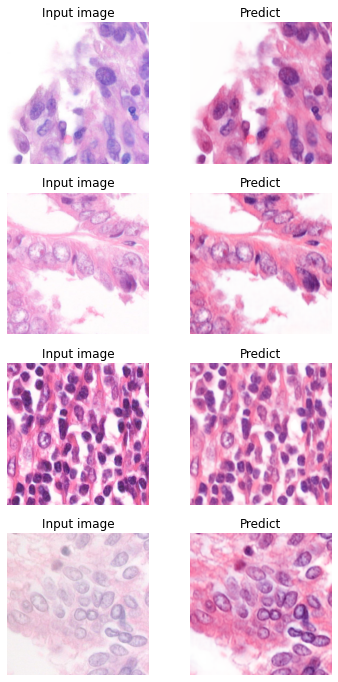

In [31]:

_,ax = plt.subplots(4, 2, figsize=(6, 12))
for i, img in enumerate(zip(tf_x_file.take(10),tf_y_file.take(10))):
    prediction = cycle_gan_model.gen_G(img[0])[0].numpy()
    ax[i, 0].imshow(pred_x[i].astype(np.uint8))
    ax[i, 1].imshow((prediction*127.5+127.5).astype(np.uint8))
    ax[i, 0].set_title("Input image")
    ax[i, 1].set_title("Predict")
  
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
